# Selecting Solver: ALGAMES, iLQGames
This notebook demonstrates how to switch between ALGAMES [1] and iLQGames [2], to solve a dynamic game problem. The one the main difference between the two algorithms is the way constraint are handled. 
- For iLQGames you have to specify a penalty factor for violating the constraints. Hhigher penalty means 
    - better constraint satisfaction in general,
    - worse numerical conditioning,
    - longer solve time,
- For ALGAMES, the constraints are handled via an augmented Lagrangian algorithm, no penalty tuning is required. 


[1] Le Cleac'h, Simon, Mac Schwager, and Zachary Manchester. "ALGAMES: A Fast Solver for Constrained Dynamic Games." arXiv preprint arXiv:1910.09713 (2019).

[2] Fridovich-Keil, David, et al. "Efficient Iterative Linear-Quadratic Approximations for Nonlinear Multi-Player General-Sum Differential Games." arXiv preprint arXiv:1909.04694 (2019).

In [2]:
using ALGAMES
using BenchmarkTools
using LinearAlgebra
using StaticArrays
using TrajectoryOptimization
const TO = TrajectoryOptimization;

### Define the dynamics model of the game.

In [3]:
struct InertialUnicycleGame{T} <: AbstractGameModel
    n::Int  # Number of states
    m::Int  # Number of controls
    mp::T
    pu::Vector{Vector{Int}} # Indices of the each player's controls
    px::Vector{Vector{Int}} # Indices of the each player's x and y positions
    p::Int  # Number of players
end
InertialUnicycleGame() = InertialUnicycleGame(
    12,
    6,
    1.0,
    [[1,2],[3,4],[5,6]],
    [[1,2],[5,6],[9,10]],
    3)
Base.size(::InertialUnicycleGame) = 12,6,[[1,2],[3,4],[5,6]],3 # n,m,pu,p

### Instantiate dynamics model

In [4]:
model = InertialUnicycleGame()
n,m,pu,p = size(model)
T = Float64
px = model.px

# We use the unicycle dynamics for each player. 
# State   x = [px1, py1, θ1, v1, px2, py2, θ2, v2, px3, py3, θ3, v3] 
# Control u = [θ1, v1, θ2, v2, θ3, v3]
# px1 = x position of player 1 
# py1 = y position of player 1 
# θ1 = orientation of player 1 
# v1 = x velocity of player 1 

function TO.dynamics(model::InertialUnicycleGame, x, u) # Non memory allocating dynamics
    qd1 = @SVector [cos(x[3]), sin(x[3])]
    qd1 *= x[4]
    qd2 = @SVector [cos(x[7]), sin(x[7])]
    qd2 *= x[8]
    qd3 = @SVector [cos(x[11]), sin(x[11])]
    qd3 *= x[12]
    qdd1 = u[ @SVector [1,2] ]
    qdd2 = u[ @SVector [3,4] ]
    qdd3 = u[ @SVector [5,6] ]
    return [qd1; qdd1; qd2; qdd2; qd3; qdd3]
end;

### Discretization of the trajectories

In [5]:
tf = 3.0  # final time
N = 41    # number of knot points
dt = tf / (N-1); # time step duration

### Initial and final state definition

In [6]:
# Define initial and final states (be sure to use Static Vectors!)
x0 = @SVector  [
               -0.80, -0.05,  0.00, 0.60, #player 1 x,y,θ,v
               -1.00, -0.05,  0.00, 0.60, #player 2 x,y,θ,v
               -0.90, -0.30, pi/12, 0.63, #player 3 x,y,θ,v
                ]
xf = @SVector [
                1.10, -0.05,  0.00, 0.60, #player 1 x,y,θ,v
                0.70, -0.05,  0.00, 0.60, #player 2 x,y,θ,v
                0.90, -0.05,  0.00, 0.60, #player 3 x,y,θ,v
               ];

### Define players objective functions

In [7]:
# Define quadratic costs
diag_Q1 = @SVector [ # Player 1 state cost
    0., 10., 1., 1.,
    0., 0., 0., 0.,
    0., 0., 0., 0.]
diag_Q2 = @SVector [ # Player 2 state cost
    0., 0., 0., 0.,
    0., 10., 1., 1.,
    0., 0., 0., 0.]
diag_Q3 = @SVector [ # Player 3 state cost
    0., 0., 0., 0.,
    0., 0., 0., 0.,
    0., 10., 1., 1.]

# Players stage state costs
Q = [0.1*Diagonal(diag_Q1), 
     0.1*Diagonal(diag_Q2),
     0.1*Diagonal(diag_Q3)]

# Players final state costs
Qf = [1.0*Diagonal(diag_Q1),
      1.0*Diagonal(diag_Q2),
      1.0*Diagonal(diag_Q3)]

# Players controls costs
R = [0.1*Diagonal(@SVector ones(length(pu[1]))),
     0.1*Diagonal(@SVector ones(length(pu[2]))),
     0.1*Diagonal(@SVector ones(length(pu[3]))),
    ]

# Players objectives
obj = [LQRObjective(Q[i],R[i],Qf[i],xf,N) for i=1:p];

### Define the initial trajectory

In [8]:
xs = SVector{n}(zeros(n))
us = SVector{m}(zeros(m))
Z = [KnotPoint(xs,us,dt) for k = 1:N]
Z[end] = KnotPoint(xs,m);

### Build the ramp merging scenario

In [9]:
# Actors 
car_radius = 0.08
car_radii = [car_radius for i=1:p]
actors_types = [:car, :car, :car]

#Scene
road_length = 6.0
road_width = 0.30
ramp_length = 3.2
ramp_angle = pi/12

# Build scenario
scenario = MergingScenario(
        road_length, road_width, ramp_length, 
        ramp_angle, car_radii, actors_types);

### Define a constraint set per solver

In [10]:
# Create constraint sets
algames_conSet = ConstraintSet(n,m,N)
ilqgames_conSet = ConstraintSet(n,m,N)
con_inds = 2:N # Indices where the constraints will be applied

# Add collision avoidance constraints
add_collision_avoidance(algames_conSet, car_radii, px, p, con_inds)
add_collision_avoidance(ilqgames_conSet, car_radii, px, p, con_inds)

# Add scenario specific constraints (road boundaries)
add_scenario_constraints(algames_conSet, scenario, px, con_inds; constraint_type=:constraint)
add_scenario_constraints(ilqgames_conSet, scenario, px, con_inds; constraint_type=:constraint);

### Define one problem per solver

In [11]:
algames_prob = GameProblem(model, obj, algames_conSet, x0, xf, Z, N, tf);
ilqgames_prob = GameProblem(model, obj, ilqgames_conSet, x0, xf, Z, N, tf);

### Build the ALGAMES solver 

In [15]:
# AlGAMES
algames_opts = DirectGamesSolverOptions{T}(
    iterations=10,
    inner_iterations=20,
    iterations_linesearch=10)
algames_solver = DirectGamesSolver(algames_prob, algames_opts);

# iLQGames
ilqgames_opts = PenaltyiLQGamesSolverOptions{T}(
    iterations=200,
    iterations_linesearch=10)
ilqgames_solver = PenaltyiLQGamesSolver(ilqgames_prob, ilqgames_opts)

# Tune this penalty parameter to get better constraint satisfaction for iLQGames
pen = 100.0 * ones(length(ilqgames_solver.constraints)) 
set_penalty!(ilqgames_solver, pen);

### Solve the problem

In [16]:
@time solve!(algames_solver);

  0.037675 seconds (13.62 k allocations: 11.961 MiB)


┌ Info: ("Solver iteration = ", 1)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/direct/direct_methods.jl:39
┌ Info: ("Solver iteration = ", 2)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/direct/direct_methods.jl:39
┌ Info: ("Solver iteration = ", 3)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/direct/direct_methods.jl:39
┌ Info: ("Solver iteration = ", 4)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/direct/direct_methods.jl:39
┌ Info: Outer loop converged: cost_tolerance & constraint_tolerance
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/direct/direct_methods.jl:146


In [17]:
@time solve!(ilqgames_solver);

┌ Info: ("Solver iteration = ", 1)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/riccati/penalty_ilqgames/penalty_ilqgames_methods.jl:50
┌ Info: ("Solver iteration = ", 2)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/riccati/penalty_ilqgames/penalty_ilqgames_methods.jl:50
┌ Info: ("Solver iteration = ", 3)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/riccati/penalty_ilqgames/penalty_ilqgames_methods.jl:50
┌ Info: ("Solver iteration = ", 4)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/riccati/penalty_ilqgames/penalty_ilqgames_methods.jl:50
┌ Info: ("Solver iteration = ", 5)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/riccati/penalty_ilqgames/penalty_ilqgames_methods.jl:50
┌ Info: ("Solver iteration = ", 6)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/riccati/penalty_ilqgames/penalty_ilqgames_methods.jl:50
┌ Info: ("Solver itera

  0.233107 seconds (693.65 k allocations: 208.817 MiB, 43.73% gc time)


┌ Info: ("Solver iteration = ", 11)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/riccati/penalty_ilqgames/penalty_ilqgames_methods.jl:50
┌ Info: ("Solver iteration = ", 12)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/riccati/penalty_ilqgames/penalty_ilqgames_methods.jl:50
┌ Info: ("Solver iteration = ", 13)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/riccati/penalty_ilqgames/penalty_ilqgames_methods.jl:50
┌ Info: ("Solver iteration = ", 14)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/riccati/penalty_ilqgames/penalty_ilqgames_methods.jl:50
┌ Info: ("Solver iteration = ", 15)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/riccati/penalty_ilqgames/penalty_ilqgames_methods.jl:50
┌ Info: ("Solver iteration = ", 16)
└ @ ALGAMES /home/kantorovich/.julia/packages/ALGAMES/gNlVw/src/solvers/riccati/penalty_ilqgames/penalty_ilqgames_methods.jl:50
┌ Info: gradient

### Evaluate the solve time

In [18]:
reset!(algames_solver, reset_type=:full)
algames_solver.opts.log_level = TO.Logging.Warn
@btime timing_solve(algames_solver);

  33.438 ms (15403 allocations: 11.77 MiB)


In [19]:
reset!(ilqgames_solver, reset_type=:full)
ilqgames_solver.opts.log_level = TO.Logging.Warn
@btime timing_solve(ilqgames_solver);

  112.475 ms (695388 allocations: 209.04 MiB)


### Visualize solver iterations

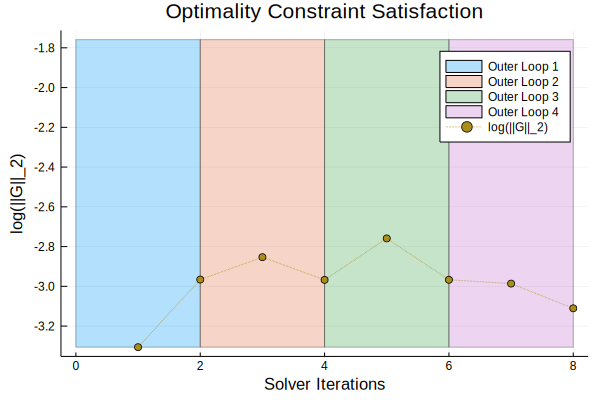

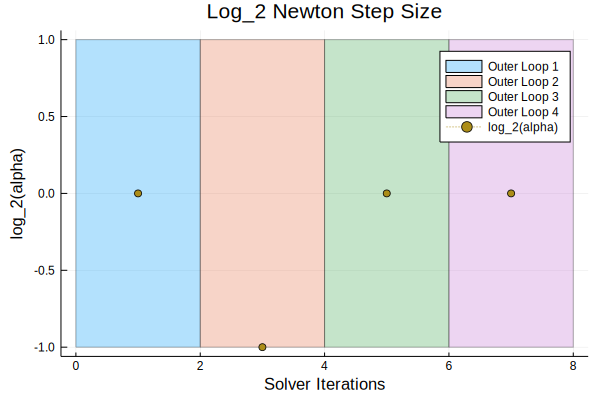

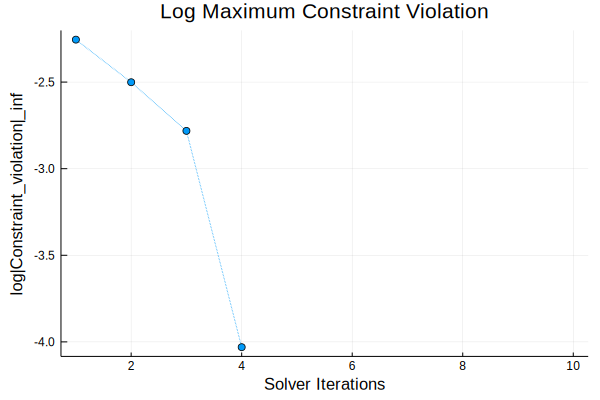

In [20]:
visualize_optimality_merit(algames_solver)
visualize_α(algames_solver)
visualize_cmax(algames_solver)

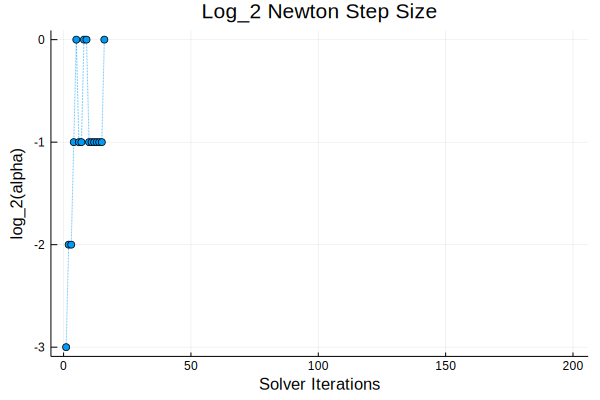

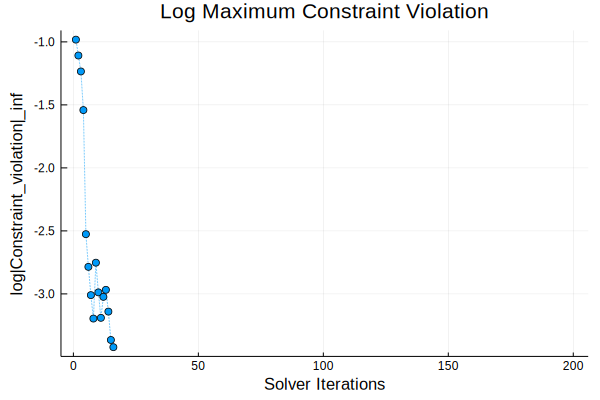

In [21]:
visualize_α(ilqgames_solver)
visualize_cmax(ilqgames_solver)